In [204]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
import scipy.stats as stats
import seaborn as sns

In [149]:
df = pd.read_csv('Resources/98-401-X2021002_English_CSV_data.csv', encoding='ISO-8859-1')

In [150]:
#reducing columns
columns_to_keep=['GEO_NAME','CHARACTERISTIC_ID','CHARACTERISTIC_NAME','C1_COUNT_TOTAL']
reduced_df=df[columns_to_keep]

In [151]:
#grabbing just the population for each city
pop_df = reduced_df[reduced_df['CHARACTERISTIC_ID'] == 1]
pop_group=pop_df.groupby(['GEO_NAME','CHARACTERISTIC_NAME'])
pop_group['C1_COUNT_TOTAL'].max().sort_values(ascending=False).head(15)

GEO_NAME                          CHARACTERISTIC_NAME
Toronto                           Population, 2021       6202225.0
Montréal                          Population, 2021       4291732.0
Vancouver                         Population, 2021       2642825.0
Ottawa - Gatineau                 Population, 2021       1488307.0
Calgary                           Population, 2021       1481806.0
Edmonton                          Population, 2021       1418118.0
Ottawa - Gatineau (Ontario part)  Population, 2021       1135014.0
Québec                            Population, 2021        839311.0
Winnipeg                          Population, 2021        834678.0
Hamilton                          Population, 2021        785184.0
Kitchener - Cambridge - Waterloo  Population, 2021        575847.0
London                            Population, 2021        543551.0
Halifax                           Population, 2021        465703.0
St. Catharines - Niagara          Population, 2021        433604.0
Windsor 

In [152]:
#filtering by top 15 cities by population
top_15_cities = pop_group['C1_COUNT_TOTAL'].max().sort_values(ascending=False).head(15)
top_15_cities = top_15_cities.index.get_level_values(0)
mask = reduced_df['GEO_NAME'].isin(top_15_cities)
top_15_pop_df = reduced_df[mask]

In [153]:
#get the names of the top 15 cities
cities = top_15_pop_df['GEO_NAME'].unique()
income_data = []

In [154]:
#get city name and median income for each city
for city in cities:

    city_row = top_15_pop_df[(top_15_pop_df['GEO_NAME']==city) & (top_15_pop_df['CHARACTERISTIC_ID'] == 119)]
    city_name = city_row['GEO_NAME'].iloc[0]
    median_income = city_row['C1_COUNT_TOTAL'].iloc[0]

    income_data.append({
        "City":city_name,
        "Median Income":median_income
    })

income_df = pd.DataFrame(income_data)    

In [155]:
income_df

,City,Median Income
0,Halifax,38400.0
1,Québec,41600.0
2,Montréal,36400.0
3,Ottawa - Gatineau,46400.0
4,Ottawa - Gatineau (Ontario part),47200.0
5,Toronto,38800.0
6,Hamilton,39600.0
7,St. Catharines - Niagara,29400.0
8,Kitchener - Cambridge - Waterloo,40400.0
9,London,35600.0


In [156]:
weather_df = pd.read_csv('Output/weather_data.csv')
columns_to_keep=['City','Max Temp','Wind Speed']
weather_df= weather_df[columns_to_keep]
#weather_df=weather_df.rename(columns={'GEO':'City'})
weather_df.head(15)

,City,Max Temp,Wind Speed
0,Halifax,-1.00,3.09
1,Québec,-1.07,11.32
2,Montréal,4.08,5.14
3,Gatineau,1.62,3.09
4,Ottawa,1.48,3.09
5,Toronto,6.22,10.80
6,Hamilton,5.10,12.86
7,St. Catharines,5.84,10.80
8,Kitchener,3.57,10.29
9,London,4.18,9.26


In [157]:
merged_df = pd.merge(income_df,weather_df,on='City',how='inner')
merge_to_keep = ['City','Median Income','Max Temp','Wind Speed']
merged_df = merged_df[merge_to_keep]

In [158]:
merged_data=pd.read_csv('Output/merged_data.csv')

In [159]:
merged_data

,Unnamed: 0,GEO,City_y,Crime Severity Index Value in 2021,Median Income,Wind Speed,Max Temp
0,0,Halifax,Halifax,65.72,38400.0,3.09,-1.00
1,1,Québec,Québec,42.61,41600.0,11.32,-1.07
2,2,Montréal,Montréal,55.93,36400.0,5.14,4.08
3,3,Ottawa - Gatineau,Gatineau,49.57,46400.0,3.09,1.62
4,4,Ottawa - Gatineau (Ontario part),Ottawa,49.25,47200.0,3.09,1.48
5,5,Toronto,Toronto,45.45,38800.0,10.80,6.22
6,6,Hamilton,Hamilton,56.85,39600.0,12.86,5.10
7,7,St. Catharines - Niagara,St. Catharines,62.12,29400.0,10.80,5.84
8,8,Kitchener - Cambridge - Waterloo,Kitchener,79.39,40400.0,10.29,3.57
9,9,London,London,80.09,35600.0,9.26,4.18


## Temperature vs Median Income

In [160]:
def linear_regression(x,y, tickinterval=None):
    
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    regress_values = x * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

    plt.scatter(x,y)
    plt.plot(x,regress_values,"r-")
    plt.annotate(line_eq,(x.min(), regress_values.max()),fontsize=15,color="red")
    print(f'The r-value is {rvalue}')

    #plt.xlim(0.9 * x.min(), 1.1 * x.max())
    
    if tickinterval is not None:
        plt.xticks(np.arange(x.min(), x.max()+tickinterval, tickinterval))

The r-value is -0.13643150617171979


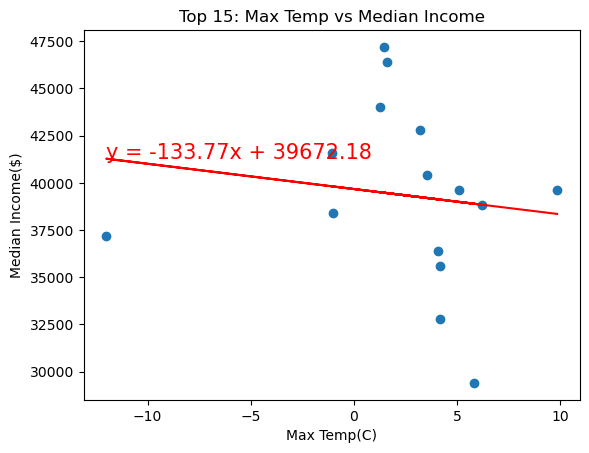

In [161]:
y_values_15 = merged_data['Median Income']
x_values = merged_data['Max Temp']
linear_regression(x_values,y_values_15)
plt.xlabel('Max Temp(C)')
plt.ylabel('Median Income($)')
plt.title('Top 15: Max Temp vs Median Income')
plt.savefig('Output/top15_MaxTempvsMedianIncome.png')

## Analysis
There is a weak negative correlation between max temperature and median income in the top 15 cities.  As the temperature increases the median income decreases.  However, there are other factors that would influence this value. 

In [162]:
#stats.ttest_ind(y_values_15,y_values_all.mean())

In [163]:
#filter for the value you want and sort so they're in order.
median_income_df = reduced_df[reduced_df['CHARACTERISTIC_ID'] == 119][['GEO_NAME', 'C1_COUNT_TOTAL']].sort_values(by='C1_COUNT_TOTAL',ascending=False)
city_name=median_income_df['GEO_NAME'].unique()
income_data2=[]

In [164]:
median_income_df

,GEO_NAME,C1_COUNT_TOTAL
336886,Wood Buffalo,79500.0
418447,Yellowknife,73500.0
152716,Petawawa,57600.0
415816,Whitehorse,56000.0
413185,Fort St. John,51200.0
...,...,...
42214,Campbellton,27600.0
115882,Sainte-Agathe-des-Monts,27400.0
47476,Campbellton (Quebec part),26000.0
384244,Parksville,26000.0


In [165]:
#add a median income rank
i=1
for city in city_name:
    
    city_row = median_income_df[median_income_df['GEO_NAME']==city]
    city_name = city_row['GEO_NAME'].iloc[0]
    median_income = city_row['C1_COUNT_TOTAL'].iloc[0]
    income_rank = i

    income_data2.append({
        "City":city_name,
        "Median Income":median_income,
        "Total Rank": income_rank
    })
    i+=1
income_df2=pd.DataFrame(income_data2)

In [166]:
income_df2

,City,Median Income,Total Rank
0,Wood Buffalo,79500.0,1
1,Yellowknife,73500.0,2
2,Petawawa,57600.0,3
3,Whitehorse,56000.0,4
4,Fort St. John,51200.0,5
...,...,...,...
155,Campbellton,27600.0,156
156,Sainte-Agathe-des-Monts,27400.0,157
157,Campbellton (Quebec part),26000.0,158
158,Parksville,26000.0,159


In [167]:
#rename to city so we can compare to the top_15_cities
income_df2 = income_df2.rename(columns={'City':'GEO_NAME'})

In [168]:
#filter for top 15 cities
mask = income_df2['GEO_NAME'].isin(top_15_cities)
top_15_income = income_df2[mask]

In [169]:
#export to csv
top_15_income.to_csv('Output/income_data.csv',index=False)

In [170]:
#rename so we can merge on 'City'
income_df2 = income_df2.rename(columns={'GEO_NAME':'City'})

In [171]:
weather_df2= pd.read_csv('Output/weather_data_larger_set.csv')
merged_df2 = pd.merge(income_df2,weather_df2,on='City',how='inner')

The r-value is -0.23147790945775684


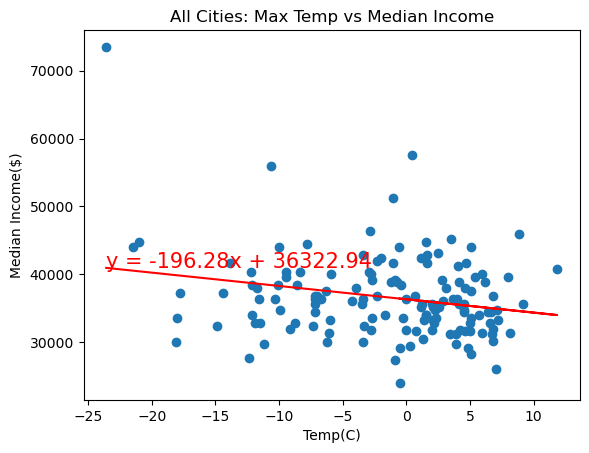

In [172]:
x_values = merged_df2['Max Temp']
y_values_all = merged_df2['Median Income']
linear_regression(x_values,y_values_all)
plt.xlabel("Temp(C)")
plt.ylabel("Median Income($)")
plt.title('All Cities: Max Temp vs Median Income')
plt.savefig('Output/AllCities_MaxTempvsMedianIncome.png')


## Analysis
There is a stronger negative correlation when looking at all of the cities in Canada.  However, it is still not strong enough to draw any conclusions from

## One Sample T-Test

In [193]:
top_15_mean = y_values_15.mean()
population_mean = y_values_all.mean()
stats.ttest_1samp(y_values_15,population_mean)

Ttest_1sampResult(statistic=2.1832802482169664, pvalue=0.04653460152476595)

In [196]:
print(f'Top 15 mean:{top_15_mean} \n Whole mean:{population_mean}')

Top 15 mean:39346.666666666664 
 Whole mean:36644.68085106383


In [197]:
top_15_income

,GEO_NAME,Median Income,Total Rank
5,Ottawa - Gatineau (Ontario part),47200.0,6
6,Ottawa - Gatineau,46400.0,7
17,Edmonton,44000.0,18
22,Calgary,42800.0,23
29,Québec,41600.0,30
34,Kitchener - Cambridge - Waterloo,40400.0,35
43,Hamilton,39600.0,44
44,Vancouver,39600.0,45
49,Toronto,38800.0,50
55,Halifax,38400.0,56


The pvalue is less than .05, which means the median income of the top 15 cities is significantly different than the whole of Canada.

In [187]:
top_15_income


,GEO_NAME,Median Income,Total Rank
5,Ottawa - Gatineau (Ontario part),47200.0,6
6,Ottawa - Gatineau,46400.0,7
17,Edmonton,44000.0,18
22,Calgary,42800.0,23
29,Québec,41600.0,30
34,Kitchener - Cambridge - Waterloo,40400.0,35
43,Hamilton,39600.0,44
44,Vancouver,39600.0,45
49,Toronto,38800.0,50
55,Halifax,38400.0,56


In [190]:
def one_way_anova(group):
    if len(group) > 1:
        values = [group[group.index == name].iloc[0]['Median Income'] for name in group.index]
        return stats.f_oneway(*values)
    else:
        return np.nan

In [191]:
grouped_df = top_15_income.groupby('GEO_NAME')['Median Income']

In [192]:
results = grouped_df.apply(one_way_anova).dropna()
print(results)

Series([], Name: Median Income, dtype: float64)


In [ ]:
merged_df2.groupby(['City','Max Temp'])['Median Income'].max().sort_values(ascending=False).tail(25)

In [ ]:
pop = reduced_df[reduced_df['CHARACTERISTIC_ID'] == 1]['C1_COUNT_TOTAL']
income=income_df2['Median Income']

## Population vs Median Income

In [ ]:
# having trouble getting this to look nice on a graph. Also not 100% sure I understand non-linear regression

In [ ]:
y_values=income
x_values=pop
linear_regression(x_values,y_values,tickinterval=1000000)
plt.title("Population vs Median Income")
plt.ylabel('Median Income($)')
plt.xlabel('Population(mil)')

In [ ]:
def non_linear_regression(x, y, degree=2):
    x = np.array(x)
    y = np.array(y)
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(x.reshape(-1, 1))
    model = LinearRegression()
    model.fit(X_poly, y)
    return model, poly
    

In [ ]:
x_values_np = x_values.to_numpy()
model, poly = non_linear_regression(x_values, y_values, degree=2)
predictions = model.predict(poly.fit_transform(x_values_np.reshape(-1, 1)))

In [ ]:
plt.scatter(x_values, y_values)
plt.plot(x_values, predictions, color='red')
plt.xscale("log")
plt.xlabel("Population")
plt.ylabel("Median Income")
plt.show()